In [ ]:
import os
import re
import json
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input,
    LSTM,
    Dense,
    Embedding,
    Dropout,
    LayerNormalization,
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

from nltk.translate.bleu_score import (
    SmoothingFunction,
    corpus_bleu
)
from rouge_score import rouge_scorer

nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Final Tuned LSTM

In [ ]:
MAX_QUESTION_LENGTH = 50
MAX_ANSWER_LENGTH = 200
EMBEDDING_DIM = 256
LATENT_DIM = 512
BATCH_SIZE = 128
EPOCHS = 100
VALIDATION_SPLIT = 0.2
TEST_SPLIT = 0.2
LEARNING_RATE = 1e-4
CLIP_NORM = 1.0
BEAM_WIDTH = 3
TEMPERATURE = 1.0

## Data Preprocessing

In [ ]:
def augment_data(question, answer):
    augmented_pairs = []
    # Original pair
    augmented_pairs.append((question, answer))

    # Remove punctuation version
    q_no_punct = re.sub(r'[.,!?]', '', question)
    augmented_pairs.append((q_no_punct, answer))

    # Shuffle words slightly (maintaining rough meaning)
    words = question.split()
    if len(words) > 3:
        for i in range(min(3, len(words)-1)):
            shuffled = words.copy()
            shuffled[i], shuffled[i+1] = shuffled[i+1], shuffled[i]
            augmented_pairs.append((' '.join(shuffled), answer))

    return augmented_pairs

def get_synonyms(word):
    try:
        synonyms = []
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.name() != word and '_' not in lemma.name():
                    synonyms.append(lemma.name())
        return list(set(synonyms))
    except LookupError:
        nltk.download('wordnet')
        return get_synonyms(word)
    except Exception as e:
        print(f"Synonym error: {str(e)}")
        return []

def advanced_augment_data(question, answer, augmentation_factor=3):
    augmented_pairs = [(question, answer)]

    # 1. Synonym replacement
    words = question.split()
    for _ in range(min(3, len(words))):
        new_words = words.copy()
        idx = random.randint(0, len(words)-1)
        synonyms = get_synonyms(words[idx])
        if synonyms:
            new_words[idx] = random.choice(synonyms)
            augmented_pairs.append((' '.join(new_words), answer))

    # 2. Random deletion
    if len(words) > 4:
        new_words = [word for word in words if random.random() > 0.2]
        if new_words:
            augmented_pairs.append((' '.join(new_words), answer))

    # 3. Word order variations
    if len(augmented_pairs) < augmentation_factor:
        if len(words) > 3:
            for i in range(min(2, len(words)-1)):
                shuffled = words.copy()
                shuffled[i], shuffled[i+1] = shuffled[i+1], shuffled[i]
                augmented_pairs.append((' '.join(shuffled), answer))

    # 4. Remove punctuation version
    q_no_punct = re.sub(r'[.,!?]', '', question)
    if q_no_punct != question:
        augmented_pairs.append((q_no_punct, answer))

    return augmented_pairs[:augmentation_factor]

def load_data(dataset_path):
    data = []
    for file in sorted(os.listdir(dataset_path)):
        if file.endswith(".json"):
            with open(os.path.join(dataset_path, file), "r", encoding="utf-8") as f:
                content = json.load(f)
                qa_pairs = content.get("qa_pairs", [])
                for pair in qa_pairs:
                    augmented = augment_data(pair["question"], pair["answer"])
                    for q, a in augmented:
                        data.append({"question": q, "answer": a})
    return pd.DataFrame(data)

def improved_clean_text(text):
    text = text.lower().strip()
    # Preserve more meaningful punctuation and symbols
    text = re.sub(r'[^\w\s.,!?\'"-:;$%#@&*()]', ' ', text)
    # Normalize numbers
    text = re.sub(r'\d+', 'NUM', text)
    # Normalize spaces
    text = re.sub(r'\s+', ' ', text)
    return f"<START> {text} <END>"

def preprocess_data(df):
    df["question"] = df["question"].apply(improved_clean_text)
    df["answer"] = df["answer"].apply(improved_clean_text)

    # Create tokenizers with additional special tokens
    question_tokenizer = Tokenizer(oov_token="<UNK>", filters='')
    answer_tokenizer = Tokenizer(oov_token="<UNK>", filters='')

    # Add padding token
    question_tokenizer.word_index['<PAD>'] = 0
    answer_tokenizer.word_index['<PAD>'] = 0

    # Fit tokenizers
    question_tokenizer.fit_on_texts(df["question"])
    answer_tokenizer.fit_on_texts(df["answer"])

    # Convert to sequences
    question_sequences = question_tokenizer.texts_to_sequences(df["question"])
    answer_sequences = answer_tokenizer.texts_to_sequences(df["answer"])

    # Pad sequences
    question_padded = pad_sequences(question_sequences, maxlen=MAX_QUESTION_LENGTH, padding='post')
    answer_padded = pad_sequences(answer_sequences, maxlen=MAX_ANSWER_LENGTH, padding='post')

    return question_padded, answer_padded, question_tokenizer, answer_tokenizer

## Model Building

In [ ]:
def build_improved_model(vocab_size_q, vocab_size_a):
    # Encoder
    encoder_inputs = Input(shape=(MAX_QUESTION_LENGTH,), name='encoder_input')

    # Embedding
    encoder_embedding = Embedding(
        vocab_size_q,
        EMBEDDING_DIM,
        mask_zero=True,
        embeddings_initializer='glorot_uniform',
        name='encoder_embedding'
    )
    encoder_embed = encoder_embedding(encoder_inputs)

    # Dropout rate
    encoder_dropout1 = Dropout(0.5)(encoder_embed)

    encoder_lstm = LSTM(
        LATENT_DIM,
        return_state=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        kernel_regularizer=tf.keras.regularizers.l2(1e-4),
        recurrent_regularizer=tf.keras.regularizers.l2(1e-4),
        name='encoder_lstm'
    )

    encoder_outputs, state_h, state_c = encoder_lstm(encoder_dropout1)

    # Layer normalization
    state_h = LayerNormalization()(state_h)
    state_c = LayerNormalization()(state_c)

    # Decoder
    decoder_inputs = Input(shape=(MAX_ANSWER_LENGTH-1,), name='decoder_input')

    decoder_embedding = Embedding(
        vocab_size_a,
        EMBEDDING_DIM,
        mask_zero=True,
        embeddings_initializer='glorot_uniform',
        name='decoder_embedding'
    )
    decoder_embed = decoder_embedding(decoder_inputs)

    decoder_dropout1 = Dropout(0.5)(decoder_embed)

    decoder_lstm = LSTM(
        LATENT_DIM,
        return_sequences=True,
        return_state=True,
        kernel_initializer='glorot_uniform',
        recurrent_initializer='orthogonal',
        name='decoder_lstm'
    )

    decoder_outputs, _, _ = decoder_lstm(decoder_dropout1, initial_state=[state_h, state_c])

    # Layer normalization
    decoder_outputs = LayerNormalization()(decoder_outputs)

    # Final dropout before dense layer
    decoder_dropout2 = Dropout(0.5)(decoder_outputs)

    # Dense layer
    decoder_dense = Dense(
        vocab_size_a,
        activation='softmax',
        kernel_initializer='glorot_uniform',
        name='decoder_dense'
    )
    decoder_outputs = decoder_dense(decoder_dropout2)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    # Adam optimizer with gradient clipping
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=LEARNING_RATE,
        clipnorm=CLIP_NORM,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )

    def sparse_categorical_crossentropy_with_smoothing(y_true, y_pred, smoothing=0.1):
        num_classes = tf.cast(tf.shape(y_pred)[-1], tf.float32)
        y_true = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true, tf.shape(y_pred)[-1])

        # Apply label smoothing
        y_true_smooth = (1.0 - smoothing) * y_true_one_hot + smoothing / num_classes

        return tf.reduce_mean(
            tf.reduce_sum(-y_true_smooth * tf.math.log(y_pred + 1e-7), axis=-1)
        )

    model.compile(
        optimizer=optimizer,
        loss=sparse_categorical_crossentropy_with_smoothing,
        metrics=['accuracy', 'sparse_categorical_accuracy',
         tf.keras.metrics.SparseCategoricalCrossentropy(name='raw_crossentropy')]
    )

    print(model.summary())

    return model

In [ ]:
def create_inference_models(model, vocab_size_a):
    encoder_lstm = None
    decoder_lstm = None
    decoder_dense = None
    encoder_embedding = None
    decoder_embedding = None

    for layer in model.layers:
        if isinstance(layer, LSTM):
            if encoder_lstm is None:
                encoder_lstm = layer
            else:
                decoder_lstm = layer
        elif isinstance(layer, Dense):
            decoder_dense = layer
        elif isinstance(layer, Embedding):
            if encoder_embedding is None:
                encoder_embedding = layer
            else:
                decoder_embedding = layer

    # Create encoder model
    encoder_inputs = Input(shape=(MAX_QUESTION_LENGTH,))
    x = encoder_embedding(encoder_inputs)
    x = Dropout(0.3)(x)
    _, state_h, state_c = encoder_lstm(x)
    state_h = LayerNormalization()(state_h)
    state_c = LayerNormalization()(state_c)
    encoder_model = Model(encoder_inputs, [state_h, state_c])

    # Create decoder model
    decoder_inputs = Input(shape=(1,))
    decoder_state_input_h = Input(shape=(LATENT_DIM,))
    decoder_state_input_c = Input(shape=(LATENT_DIM,))

    x = decoder_embedding(decoder_inputs)
    x = Dropout(0.3)(x)
    decoder_outputs, state_h, state_c = decoder_lstm(
        x,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )
    decoder_outputs = LayerNormalization()(decoder_outputs)
    decoder_outputs = Dropout(0.3)(decoder_outputs)
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model(
        [decoder_inputs, decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs, state_h, state_c]
    )

    return encoder_model, decoder_model

## Evaluation functions

In [ ]:
@tf.function(reduce_retracing=True)
def predict_step(decoder_model, target_seq, h_batch, c_batch):
    return decoder_model([target_seq, h_batch, c_batch], training=False)

def optimized_beam_search_decode(encoder_model, decoder_model, input_seq, a_tokenizer,
                               beam_width=3, max_length=50, temperature=1.0,
                               early_stopping_threshold=0.001):
    # Convert input types to tensors with fixed shapes
    input_seq = tf.convert_to_tensor(input_seq, dtype=tf.float32)

    # Get encoder output (only once)
    states_value = encoder_model(input_seq, training=False)

    # Initialize beam with start token
    start_token = a_tokenizer.word_index['<start>']
    end_token = a_tokenizer.word_index['<end>']

    beams = [(([start_token], 0.0), states_value)]
    finished_beams = []

    # Cache for storing decoder outputs
    prediction_cache = {}

    for _ in range(max_length):
        if not beams:
            break

        # Prepare batched inputs with fixed shapes
        current_tokens = np.array([beam[0][0][-1] for beam in beams])
        current_states = [beam[1] for beam in beams]

        # Create batched inputs
        batch_size = len(beams)
        target_seq = tf.convert_to_tensor(
            current_tokens.reshape(batch_size, 1),
            dtype=tf.float32
        )

        cache_key = tuple(current_tokens)
        if cache_key not in prediction_cache:
            # Batch predict with fixed shapes
            h_batch = tf.convert_to_tensor(
                np.vstack([states[0] for states in current_states]),
                dtype=tf.float32
            )
            c_batch = tf.convert_to_tensor(
                np.vstack([states[1] for states in current_states]),
                dtype=tf.float32
            )

            outputs_batch = predict_step(
                decoder_model,
                target_seq,
                h_batch,
                c_batch
            )
            prediction_cache[cache_key] = outputs_batch
        else:
            outputs_batch = prediction_cache[cache_key]

        output_tokens_batch, h_batch, c_batch = outputs_batch

        candidates = []
        for i, ((seq, score), _) in enumerate(beams):
            if seq[-1] == end_token:
                finished_beams.append((seq, score))
                continue

            # Apply temperature scaling
            logits = tf.cast(output_tokens_batch[i, -1, :], tf.float32)
            scaled_logits = logits / temperature
            scaled_probs = tf.nn.softmax(scaled_logits).numpy()

            # Get top k candidates efficiently
            top_k_indices = np.argpartition(scaled_probs, -beam_width)[-beam_width:]
            top_k_probs = scaled_probs[top_k_indices]

            for idx, prob in zip(top_k_indices, top_k_probs):
                new_seq = seq + [idx]
                new_score = score + float(tf.math.log(prob + 1e-10))
                new_states = [h_batch[i:i+1], c_batch[i:i+1]]
                candidates.append(((new_seq, new_score), new_states))

        # Early stopping check
        if finished_beams:
            best_finished_score = max(score for _, score in finished_beams)
            candidates = [c for c in candidates
                        if c[0][1] + early_stopping_threshold >= best_finished_score]

        # Select top beams
        candidates.sort(key=lambda x: x[0][1], reverse=True)
        beams = candidates[:beam_width]

        # Break if all beams finished
        if all(beam[0][0][-1] == end_token for beam in beams):
            break

    # Combine finished and unfinished beams
    all_beams = finished_beams + [beam[0] for beam in beams]
    best_seq = max(all_beams, key=lambda x: x[1])[0]

    return best_seq  # Return the highest scoring sequence

# Training history plotting
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss plot
    axes[0, 0].plot(history.history['loss'], label='Training Loss')
    axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 0].set_title('Model Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()

    # Accuracy plot
    axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 1].set_title('Model Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()

    # Learning rate plot
    axes[1, 0].plot(history.history['learning_rate'], label='Learning Rate')
    axes[1, 0].set_title('Learning Rate')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')

    # Clean up and display
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluate_model_advanced(encoder_model, decoder_model, q_test, a_test, q_tokenizer, a_tokenizer,
                          beam_width=3, temperature=1.0):
    smooth = SmoothingFunction().method1
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])

    # Initialize metrics
    bleu_scores = {f'bleu_{i}': 0.0 for i in range(1, 5)}
    rouge_scores = {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0}

    # Convert test data to tensors once
    q_test = tf.convert_to_tensor(q_test, dtype=tf.float32)

    # Process in batches for efficiency
    batch_size = 32
    for i in range(0, len(q_test), batch_size):
        batch_end = min(i + batch_size, len(q_test))
        batch_q = q_test[i:batch_end]

        references = []
        hypotheses = []

        for j in range(batch_end - i):
            # Get reference tokens
            reference_tokens = [a_tokenizer.index_word.get(idx, '')
                              for idx in a_test[i + j] if idx != 0]
            reference_tokens = [token for token in reference_tokens
                              if token not in ['<start>', '<end>', '<pad>']]
            references.append([reference_tokens])

            # Generate response using optimized beam search
            decoded_sequence = optimized_beam_search_decode(
                encoder_model,
                decoder_model,
                batch_q[j:j+1],
                a_tokenizer,
                beam_width=beam_width,
                temperature=temperature
            )

            decoded_tokens = [a_tokenizer.index_word.get(idx, '')
                            for idx in decoded_sequence
                            if idx not in [a_tokenizer.word_index.get(t, 0)
                                         for t in ['<start>', '<end>', '<pad>']]]
            hypotheses.append(decoded_tokens)

            # Calculate ROUGE scores
            rouge_scores_i = rouge_scorer_instance.score(
                ' '.join(reference_tokens),
                ' '.join(decoded_tokens)
            )
            for key in rouge_scores:
                rouge_scores[key] += rouge_scores_i[key].fmeasure

        # Update BLEU scores for batch
        for i in range(1, 5):
            bleu_scores[f'bleu_{i}'] += corpus_bleu(
                references,
                hypotheses,
                weights=[1.0/i]*i,
                smoothing_function=smooth
            ) * len(references)

    # Normalize scores
    n = len(q_test)
    bleu_scores = {k: v/n for k, v in bleu_scores.items()}
    rouge_scores = {k: v/n for k, v in rouge_scores.items()}

    return bleu_scores, rouge_scores

In [ ]:
def ask_question(question, encoder_model, decoder_model, q_tokenizer, a_tokenizer, max_length=50):
    question = improved_clean_text(question)

    q_seq = q_tokenizer.texts_to_sequences([question])
    q_seq = pad_sequences(q_seq, maxlen=MAX_QUESTION_LENGTH, padding='post')

    states_value = encoder_model.predict(q_seq, verbose=0)

    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = a_tokenizer.word_index.get('<start>', 0)

    decoded_tokens = []

    while len(decoded_tokens) < max_length:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = a_tokenizer.index_word.get(sampled_token_index, '')

        if sampled_word == '<end>' or sampled_word == '':
            break

        decoded_tokens.append(sampled_word)

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]

    return ' '.join(decoded_tokens)

In [ ]:
class WarmUpLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, warmup_steps, initial_lr):
        super().__init__()
        self.warmup_steps = warmup_steps
        self.initial_lr = initial_lr
        self.step = 0

    def on_batch_begin(self, batch, logs=None):
        self.step += 1
        if self.step <= self.warmup_steps:
            lr = (self.step / self.warmup_steps) * self.initial_lr
            self.model.optimizer.learning_rate.assign(lr)

callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            min_delta=1e-4
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=10,
            min_lr=1e-6,
            verbose=1
        ),
        ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        ),
        WarmUpLearningRateScheduler(warmup_steps=100, initial_lr=LEARNING_RATE),
    ]

## Training and evaluation pipeline

Loading and preprocessing data...
Original Dataset:

                         question  \
0  What is blockchain technology?   
1   What is blockchain technology   
2  is What blockchain technology?   
3  What blockchain is technology?   
4  What is technology? blockchain   

                                              answer  
0  Blockchain is a distributed, decentralized led...  
1  Blockchain is a distributed, decentralized led...  
2  Blockchain is a distributed, decentralized led...  
3  Blockchain is a distributed, decentralized led...  
4  Blockchain is a distributed, decentralized led...  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3238 entries, 0 to 3237
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  3238 non-null   object
 1   answer    3238 non-null   object
dtypes: object(2)
memory usage: 50.7+ KB
None
Dataset after preprocessing and augmentation:

                                           

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_embedding         │ (None, 50, 256)        │        621,824 │ encoder_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_input             │ (None, 199)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 50, 256)        │              0 │ encoder_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_8 (NotEqual)    │ (None, 50)             │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, 199, 256)       │      1,620,992 │ decoder_input[0][0]    │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 512), (None,   │      1,574,912 │ dropout_12[0][0],      │
│                           │ 512), (None, 512)]     │                │ not_equal_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 199, 256)       │              0 │ decoder_embedding[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_12    │ (None, 512)            │          1,024 │ encoder_lstm[0][1]     │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_13    │ (None, 512)            │          1,024 │ encoder_lstm[0][2]     │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, 199, 512),     │      1,574,912 │ dropout_13[0][0],      │
│                           │ (None, 512), (None,    │                │ layer_normalization_1… │
│                           │ 512)]                  │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_14    │ (None, 199, 512)       │          1,024 │ decoder_lstm[0][0]     │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 199, 512)       │              0 │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_dense (Dense)     │ (None, 199, 6332)      │      3,248,316 │ dropout_14[0][0]       │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,644,028 (32.97 MB)

 Trainable params: 8,644,028 (32.97 MB)

 Non-trainable params: 0 (0.00 B)

None
Training model...
Epoch 1/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.5276 - loss: 6.2807 - raw_crossentropy: 5.8745 - sparse_categorical_accuracy: 0.5276
Epoch 1: val_loss did not improve from 3.20791
46/46 ━━━━━━━━━━━━━━━━━━━━ 30s 546ms/step - accuracy: 0.5288 - loss: 6.2542 - raw_crossentropy: 5.8442 - sparse_categorical_accuracy: 0.5288 - val_accuracy: 0.6277 - val_loss: 3.8221 - val_raw_crossentropy: 3.0047 - val_sparse_categorical_accuracy: 0.6277 - learning_rate: 1.0000e-04
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.6339 - loss: 3.7431 - raw_crossentropy: 2.8994 - sparse_categorical_accuracy: 0.6339
Epoch 2: val_loss did not improve from 3.20791
46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 535ms/step - accuracy: 0.6339 - loss: 3.7426 - raw_crossentropy: 2.8990 - sparse_categorical_accuracy: 0.6339 - val_accuracy: 0.6316 - val_loss: 3.6648 - val_raw_crossentropy: 2.8269 - val_sparse_categorical_accuracy: 0.6316 - learning_rate: 1.0000e-04
Epoch 3/100

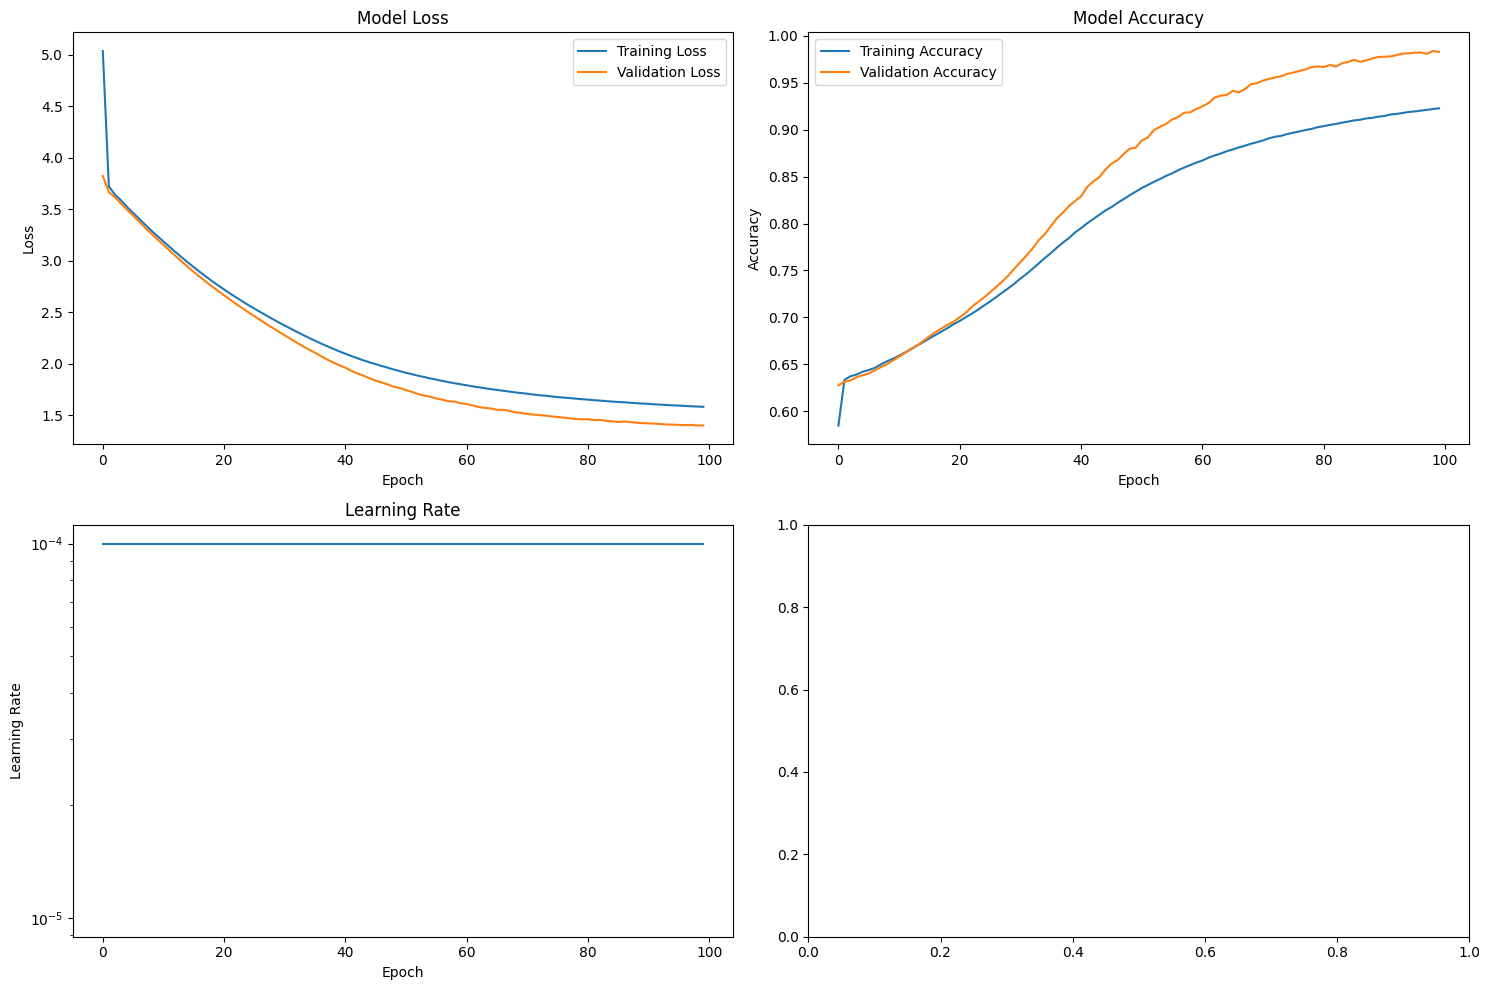

Creating inference models...
Saving models...


In [ ]:
print("Loading and preprocessing data...")
# Load data
df = load_data("dataset")
print("Original Dataset:\n")
print(df.head())
print(df.info())

# Preprocess with augmentation
augmented_data = []
for _, row in df.iterrows():
    pairs = advanced_augment_data(row['question'], row['answer'])
    augmented_data.extend(pairs)

df_augmented = pd.DataFrame(augmented_data, columns=['question', 'answer'])

q_data, a_data, q_tokenizer, a_tokenizer = preprocess_data(df_augmented)
print("Dataset after preprocessing and augmentation:\n")
print(df_augmented.head())
print(df_augmented.info())

# Split data
indices = np.arange(len(q_data))
np.random.shuffle(indices)
q_data = q_data[indices]
a_data = a_data[indices]

num_val = int(len(q_data) * VALIDATION_SPLIT)
num_test = int(len(q_data) * TEST_SPLIT)

q_train = q_data[:-num_val-num_test]
a_train = a_data[:-num_val-num_test]
q_val = q_data[-num_val-num_test:-num_test]
a_val = a_data[-num_val-num_test:-num_test]
q_test = q_data[-num_test:]
a_test = a_data[-num_test:]

print("Building model...")
# Build model
model = build_improved_model(len(q_tokenizer.word_index) + 1, len(a_tokenizer.word_index) + 1)

print("Training model...")
# Train model
history = model.fit(
    [q_train, a_train[:, :-1]],
    a_train[:, 1:],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=([q_val, a_val[:, :-1]], a_val[:, 1:]),
    callbacks=callbacks
)

# Plot training history
print("Plotting training history...")
plot_training_history(history)

# Create inference models
print("Creating inference models...")
encoder_model, decoder_model = create_inference_models(model, len(a_tokenizer.word_index) + 1)

# Save models
print("Saving models...")
model.save('full_model.keras')
encoder_model.save('encoder_model.keras')
decoder_model.save('decoder_model.keras')

In [ ]:
# Load the encoder and decoder separately
encoder_model = load_model('encoder_model.keras')
decoder_model = load_model('decoder_model.keras')

# Evaluate model
print("Evaluating model...")
bleu_scores, rouge_scores = evaluate_model_advanced(
    encoder_model, decoder_model,
    q_test, a_test,
    q_tokenizer, a_tokenizer,
    beam_width=BEAM_WIDTH,
    temperature=TEMPERATURE
)

# Print results
print("\nEvaluation Results:")
for metric, score in bleu_scores.items():
    print(f"{metric.upper()}: {score:.4f}")
for metric, score in rouge_scores.items():
    print(f"{metric.upper()}: {score:.4f}")

Evaluating model...

Evaluation Results:
BLEU_1: 0.4214
BLEU_2: 0.4010
BLEU_3: 0.3883
BLEU_4: 0.3791
ROUGE1: 0.6587
ROUGE2: 0.6040
ROUGEL: 0.6434


In [ ]:
print("Answer:", ask_question("what is blockchain ?", encoder_model, decoder_model, q_tokenizer, a_tokenizer))

Answer: blockchain is a decentralized digital currency that operates without a central authority or banks. it enables peer-to-peer transactions on a global scale through a network of computers running the bitcoin protocol. transactions are verified by network nodes through cryptography and recorded in a public distributed ledger called a blockchain. bitcoin
